<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series Rolling Statistics

_Authors:_

---

### Learning Objectives
 
#### Time Series Data
**After this lesson, you will be able to:**
- Define trend and seasonality and be able to identify these visually
- Use boxplots to compare distributions
- Plot time series data over time to identify large-scale trends in data
- Investigate trends by computing simple aggregates with pandas with the `.resample` function
- Compute rolling statistics with pandas to compare data of a date to a smaller window of time
- Utilize exponentially weighted windows to average out noise
- Use differences to remove trends in time series data

---

### Lesson Guide

#### [Time Series Data](#py_i)
TODO
- [](#)
----

## Trend and Seasonality

**QUESTION:** What constitutes a trend in data? Is linearity required for trend?

- A trend is any long-term change in the value we're measuring. Trends may “change direction”, going from an increasing trend to a decreasing trend.

- Trend can only be measured in the scope of the data collected; there may be trends that are unmeasureable if the data are not complete.

An example of an upward trend:
![] (/assets/images/trend-line2.png)

- When patterns repeat over *known, fixed periods* of time within the data set, we call this **seasonality**.

- A seasonal pattern exists when a series is influenced by factors relating to the cyclic nature of time - i.e. time of month, quarter, year, etc. Seasonality is of a fixed and known period, otherwise it is not truly seasonality, and must be either attributed to another factor or counted as a set of anomalous events in the data.


### The easiest way to visualize trends is by drawing trend lines.

       WeekOf  Hits
0  2004-01-04    53
1  2004-01-11    53
2  2004-01-18    54
3  2004-01-25    53
4  2004-02-01    52


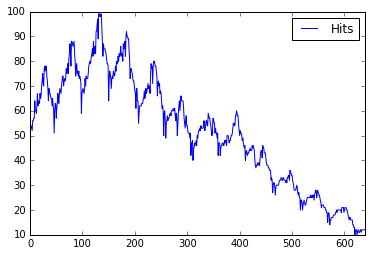

In [24]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

# Import the data
df = pd.read_csv('data/mapquest_google_trends.csv')

# Clean/Organize the data. 
df.columns = ['WeekOf', 'Hits']
print(df.head())
df.plot()

Next we need to compute a coefficient and intercept for our line. NumPy's `polyfit` method can do this.

Then define our polynomial function using that coefficient. We can do this on a single dimension using NumPy's `poly1d` method.

In [25]:
line_coef = np.polyfit(df.index,df['Hits'],1)
print(line_coef)

polynomial = np.poly1d(line_coef)
# The intercept is ~86.59, the slops is ~0.11
print(polynomial(0))
print(polynomial(1))

[ -0.10841388  86.58979622]
86.5897962168
86.4813823398


### Now plot our trendline over the data

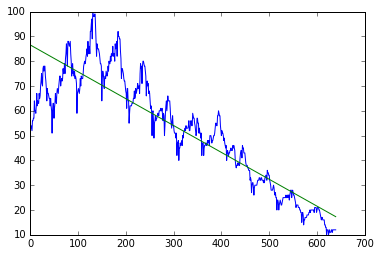

In [26]:
# Plot the time series
plt.plot(df.index, df['Hits'])
# Plot the least squares minimizing line
plt.plot(df.index, polynomial(df.index))

## Guided Practice

Let's look for trends and seasonality in data made available by a German drugstore, Rossmann.

These data contains the daily sales made at the drugstore as well as whether a sale or holiday affected the sales data.

Because we are most interested in the `Date` column (which contains the date of sales for each store), we will make sure to process that as a `DateTime` type, and make it the index of our dataframe, like we learned earlier with Apple stock data. 

Let's recall the steps to preprocessing time series data with pandas:
* Convert time data to `datetime` object
* Set `datetime` as index of Dataframe

In [27]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 8.0)

data = pd.read_csv('data/rossmann.csv', skipinitialspace=True, low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


This allows us to easily filter by date.

In [28]:
data['Year'] = data.index.year
data['Month'] = data.index.month

data['2015-05'].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-05-31,1,7,0,0,0,0,0,0,2015,5
2015-05-31,2,7,0,0,0,0,0,0,2015,5
2015-05-31,3,7,0,0,0,0,0,0,2015,5
2015-05-31,4,7,0,0,0,0,0,0,2015,5
2015-05-31,5,7,0,0,0,0,0,0,2015,5


There are over a million sales data points in this dataset, so for some simple Exploratory Data Analysis (EDA) we will focus on just one store.

In [29]:
store1_data = data[data['Store'] == 1]
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


### Plotting the sales data

We want to know how sales change over time, and whether promotions or holidays affect sales. To start, we can compare the average sales on those events.

To compare sales on holidays, we'll use boxplots.

On state holidays the store is closed (which means there are 0 sales) -- so we need to cut those days out. (Contextual knowledge like this is always needed to truly explain time series phenomenon.)

> Check: can you think of any other special considerations we should make when tracking sales?

Now check to see if there is a difference affecting sales on promotion days.

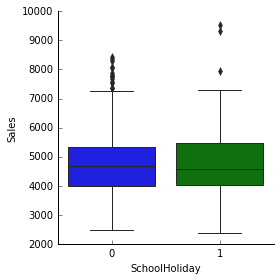

In [7]:
sns.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data[store1_data['Open']==1],
    kind='box'
)

We can see that there _is_ a difference in sales on promotion days.

Why is it important to separate out days where the store is closed? Because there aren't any promotions on those days either, so including them will bias your sales data on days without promotions! Remember to think about the business logic as well as analyzing the raw data.

We may also want to compare sales across days of the week:

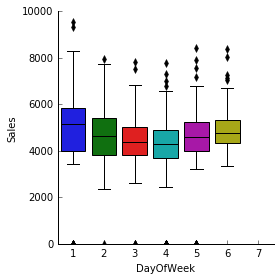

In [32]:
sns.factorplot(
    x='DayOfWeek',
    y='Sales',
    data=store1_data,
    kind='box',
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

To plot the sales and customer visits over time:

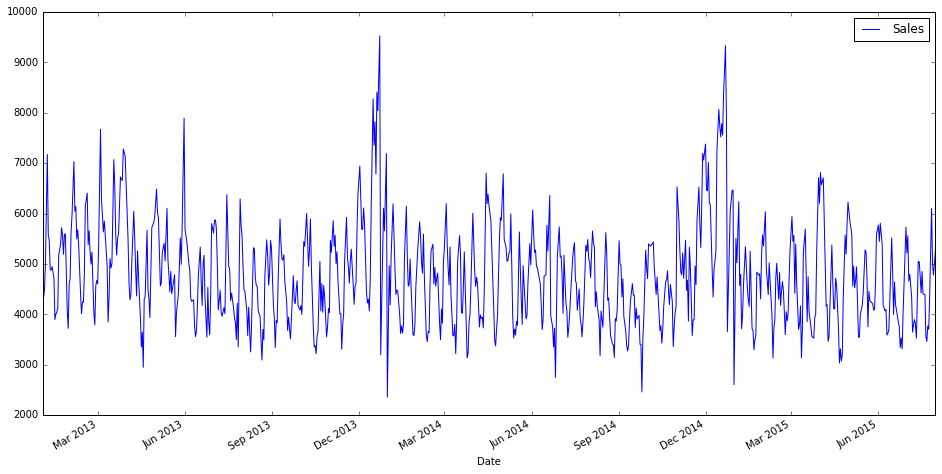

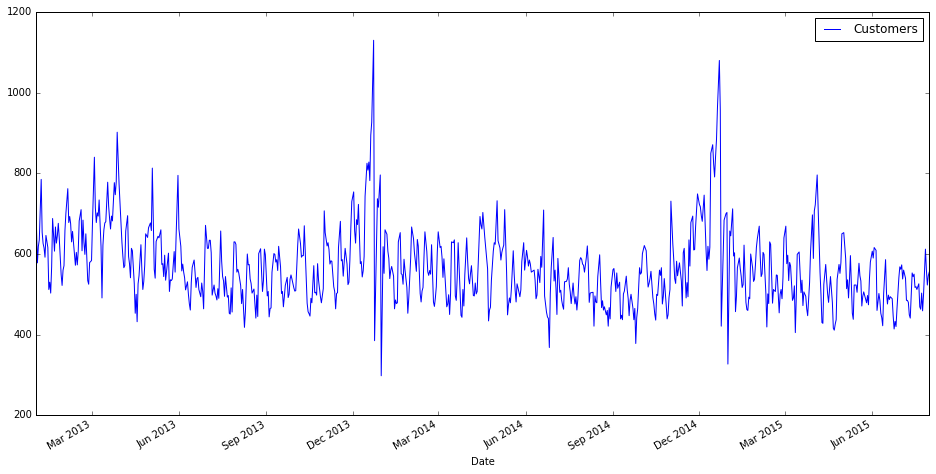

In [9]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data['Open']==1]
store1_open_data[['Sales']].plot()
store1_open_data[['Customers']].plot()

We can see that there are large spikes of sales and customers towards the end of 2013 and 2014, leading into the first quarter of 2014 and 2015.

Let's use the index filtering to filter just to 2015 changes over time. This should make it easier to identify the holiday sales bump.


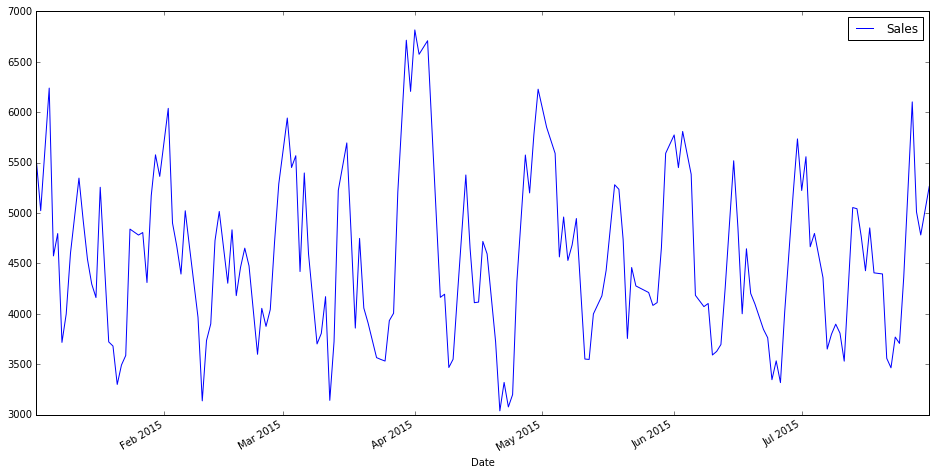

In [31]:
store1_data_2015 = store1_data['2015']
store1_data_2015[store1_data_2015.Open==1][['Sales']].plot()

## Aggregates of sales over time

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates. We want to know: what were the mean and median sales in each month and year?

We can use `data.resample` on the whole dataset and provide:
    - A parameter for the level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - The aggregation method to perform: 'mean()', 'median()', 'sum()', etc.

In [36]:
data[['Sales']].resample('A').mean()

,Sales
Date,
2013-12-31,5658.533675
2014-12-31,5833.290704
2015-12-31,5878.245380


It looks like average sales were highest in 2015. Let's look at the median annual sales.

In [37]:
data[['Sales']].resample('A').median()

,Sales
Date,
2013-12-31,5598
2014-12-31,5794
2015-12-31,5916


In [35]:
data[['Sales']].resample('M').mean()

,Sales
Date,
2013-01-31,5211.555578
2013-02-28,5494.371397
2013-03-31,5820.349168
2013-04-30,5483.749836
2013-05-31,5364.127383
2013-06-30,5402.162960
2013-07-31,6042.062260
2013-08-31,5729.574049
2013-09-30,5322.988430


In [38]:
data[['Sales']].resample('M').median()

,Sales
Date,
2013-01-31,5194.0
2013-02-28,5421.5
2013-03-31,5844.0
2013-04-30,5464.0
2013-05-31,5585.0
2013-06-30,5428.0
2013-07-31,5826.0
2013-08-31,5624.0
2013-09-30,5294.0


*Note: For more information, see Pandas' [resample documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).*

## Rolling Statistics

With time series, we can "roll" statistics across time. For example, the rolling mean is the mean of a moving window across time periods. Pandas offers a variety of functionalities for creating rolling statistics, which we'll only scratch the surface of here.

E.g. to understand holidays sales, we don't want to compare sales data in late December with the entire month, but to a few days immediately surrounding it. We can do this using rolling averages.

The syntax for these can be a little tricky at first. We'll be using a `rolling()` function with a statistical function chained to it. Let's dive into more detail.

### Parameters for `rolling()` Functions
`rolling().mean()` (as well as `rolling().median())` can take the following parameters:

* The first indicates the time series to aggregate.
* `window` indicates the number of days to include in the average.
* `center` indicates whether the window should be centered on the date or use data prior to that date.
* `freq` indicates which level to roll the averages up to (as used in `resample`): `D` for day, `M` for month, `A` for year, etc.


#### Calculate the rolling daily sum over all stores

Use the `.resample` function to calculate the daily total over all the stores

In [39]:
daily_store_sales = data[['Sales']].resample('D').sum()

Use the `.rolling` function to calculate the rolling average over a three day period.

In [40]:
daily_store_sales.rolling( window=3, center=True).mean().head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,4.464961e+06
2013-01-03,6.645534e+06
2013-01-04,6.312789e+06
2013-01-05,4.244817e+06


We can use our index filtering to just look at 2015.

In [45]:
daily_store_sales.rolling( window=7, center=True).mean()['2015'].head()

,Sales
Date,
2015-01-01,4.698837e+06
2015-01-02,5.272034e+06
2015-01-03,5.147139e+06
2015-01-04,5.822320e+06
2015-01-05,6.896103e+06


Instead of plotting the full time series, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

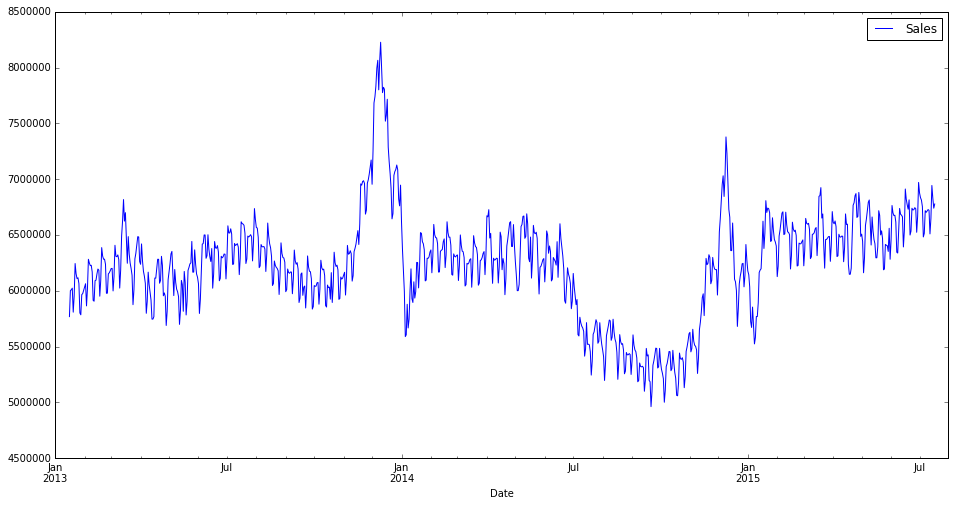

In [44]:
daily_store_sales.rolling(window=30, center=True).mean().plot()

## The expanding mean

The "expanding mean" simply uses all data points up to the current time to calculate the mean, as opposed to a moving window.

#### Calculate and plot the expanding mean below. Resample by quarter.

In [46]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=1, center=False).mean()
expanding_mean = data.Sales.resample('Q').sum().expanding().mean()

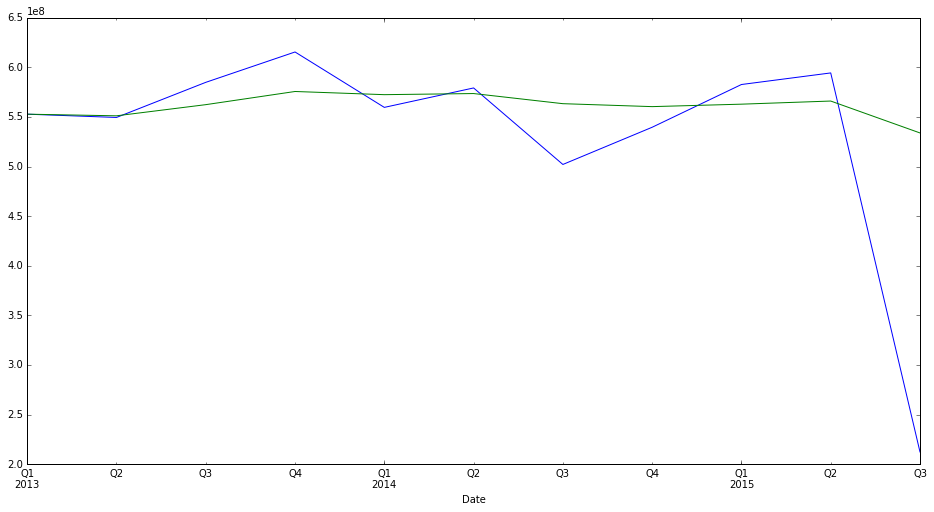

In [47]:
rolling_mean.plot()
expanding_mean.plot()

## Exponentionally weighted windows

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in time series data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of time points that are further in the past.

The (adjusted) exponentially weighted mean for time, $t$, is defined as:

<a id="-xt--fracxt-----alphaxt------alphaxt--------alphatx------alpha-----alpha-------alphat-"></a>
### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

> **Note:** Review Pandas' [documentation](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) for more information.

**Calculate and plot the exponentially weighted sum along with the rolling sum. What is the difference?**

For example: `.resample('Q').sum().ewm(span=10).mean()`.


In [48]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=2, center=True).mean()
exp_weighted_mean = data.Sales.resample('Q').sum().ewm(span=10).mean()

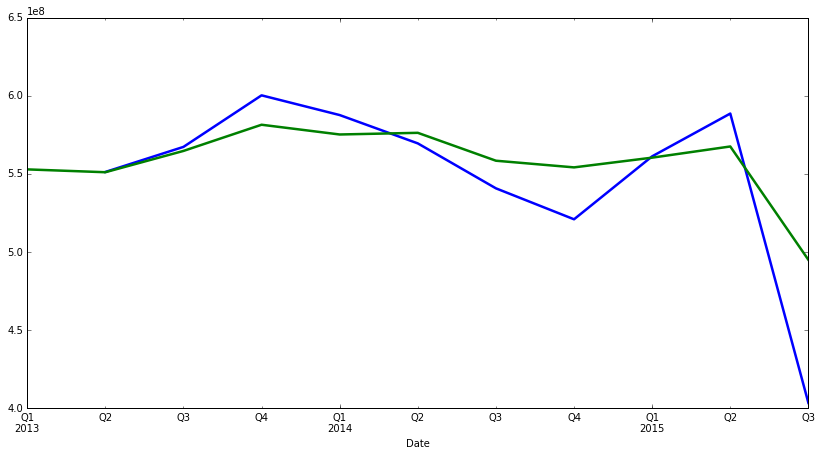

In [49]:
ax = rolling_mean.plot(lw=2.5, figsize=(14,7))
exp_weighted_mean.plot(ax=ax, lw=2.5)

## "Differencing" a Time Series and Stationarity

If a time series is stationary, the mean, variance, and autocorrelation (covered in the next section) will be constant over time. Forecasting methods typically assume the time series you are forecasting on to be stationary — or at least approximately stationary.

The most common way to make a time series stationary is through "differencing." This procedure converts a time series into the difference between values.

<a id="-delta-yt--yt---yt--"></a>
### $$ \Delta y_t = y_t - y_{t-1} $$

This removes trends in the time series and ensures that the mean across time is zero. In most cases, this only requires a single difference, although, in some cases, a second difference (or third, etc.) will be necessary to remove trends.

In [50]:
store1_data['Sales_diff'] = store1_data['Sales'].diff(periods = 7)

/Users/nicholebennett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


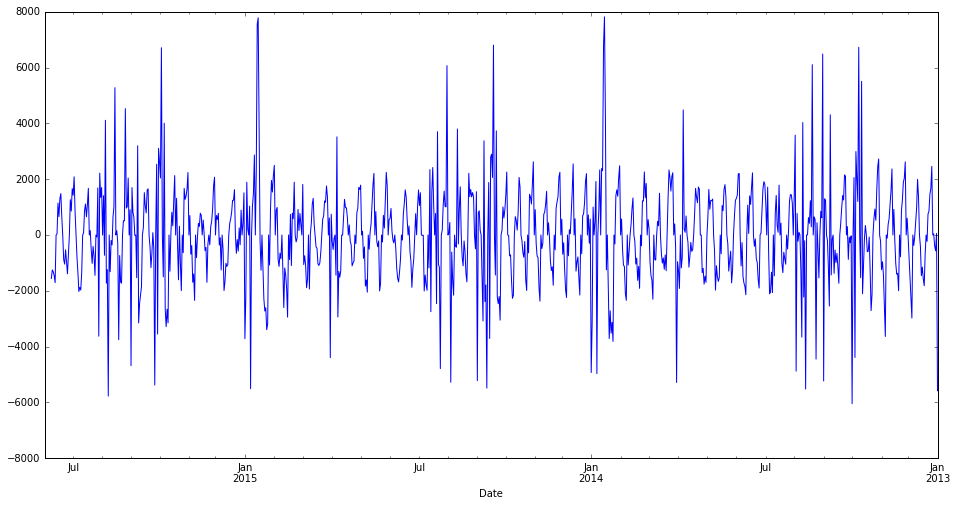

In [51]:
store1_data['Sales_diff'].plot()